#Importing libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

#Loading main dataset

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/dataset"):
  class_path = f"/content/dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

#Discarding images

In [ ]:
covid = []
lung_opacity = []
normal = []
viral_pneumonia = []
for i,j in list(zip(train_images, train_labels)):
  if j == "COVID":
    covid.append(i)
  elif j == "Lung opacity":
    lung_opacity.append(i)
  elif j == "Normal":
    normal.append(i)
  elif j == "Viral Pneumonia":
    viral_pneumonia.append(i)

In [ ]:
covid = np.array(covid)
lung_opacity = np.array(lung_opacity)
normal = np.array(normal)
viral_pneumonia = np.array(viral_pneumonia)

In [ ]:
print(f"COVID : {covid.shape}\tLung Opacity : {lung_opacity.shape}\tNormal : {normal.shape}\tViral Pneumonia : {viral_pneumonia.shape}")

COVID : (2850, 224, 224, 3)	Lung Opacity : (4831, 224, 224, 3)	Normal : (8180, 224, 224, 3)	Viral Pneumonia : (1071, 224, 224, 3)


In [ ]:
covid_selected = covid
lung_opacity_selected = lung_opacity[np.random.choice(lung_opacity.shape[0], size=lung_opacity.shape[0] - 1000)]
normal_selected = normal[np.random.choice(normal.shape[0], size=normal.shape[0] - 4000)]
viral_pneumonia_selected = viral_pneumonia

In [ ]:
print(f"COVID : {covid_selected.shape}\tLung Opacity : {lung_opacity_selected.shape}\tNormal : {normal_selected.shape}\tViral Pneumonia : {viral_pneumonia_selected.shape}")

COVID : (2850, 224, 224, 3)	Lung Opacity : (3831, 224, 224, 3)	Normal : (4180, 224, 224, 3)	Viral Pneumonia : (1071, 224, 224, 3)


In [ ]:
X_train = []
Y_train = []
for i in covid_selected:
  X_train.append(i)
  Y_train.append("COVID")
for i in lung_opacity_selected:
  X_train.append(i)
  Y_train.append("Lung opacity")
for i in normal_selected:
  X_train.append(i)
  Y_train.append("Normal")
for i in viral_pneumonia_selected:
  X_train.append(i)
  Y_train.append("Viral Pneumonia")

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
X_train.shape

(11932, 224, 224, 3)

In [ ]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)

In [ ]:
test_labels = lb.transform(test_labels)

In [ ]:
def clahe(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return bgr

In [ ]:
X_train_clahe = [clahe(i, 0.5, 8) for i in X_train]
Y_train_clahe = [i for i in Y_train]

In [ ]:
X_train.shape

(11932, 224, 224, 3)

In [ ]:
X_train_clahe = np.array(X_train_clahe)
Y_train_clahe = np.array(Y_train_clahe)

In [ ]:
X_train_final = []
Y_train_final = []
for i in range(X_train.shape[0]):
  X_train_final.append(X_train[i])
  Y_train_final.append(Y_train[i])
for i in range(X_train_clahe.shape[0]):
  X_train_final.append(X_train_clahe[i])
  Y_train_final.append(Y_train_clahe[i])

In [ ]:
X_train_final = np.array(X_train_final)
Y_train_final = np.array(Y_train_final)

In [ ]:
# X_train_final = X_train_final.astype("float16") / 255

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(Y_train_final, axis = 1)), y=np.argmax(Y_train_final, axis = 1))
model_class_weights = dict(enumerate(class_weights))

In [ ]:
model_class_weights

{0: 1.0466666666666666,
 1: 0.7786478726181154,
 2: 0.7136363636363636,
 3: 2.7852474323062557}

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

In [ ]:
X_train_final.shape

(23864, 224, 224, 3)

In [ ]:
Y_train_final.shape

(23864, 4)

#ResNet50 without class weights



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model_resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(x=X_train_final, y=Y_train_final, epochs = 20, batch_size=32, callbacks=[early_stoping], validation_split=0.2, shuffle=True)

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
final_model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 401412    
Total params: 23,989,124
Trainable params: 401,412
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.515505,0.624712,2.173946,1.442649,0.879734,0.912843,0.880149,0.913034,0.937429,0.955405,0.743719,0.775556,0.509213,0.0,0.713952,0.003143
1,0.728013,0.828096,0.935912,0.481272,0.952910,0.972554,0.952960,0.972554,0.975270,0.986237,0.927973,0.925000,0.592127,0.0,0.868378,0.003443
2,0.829462,0.791850,0.455520,1.218229,0.975695,0.938823,0.975695,0.938823,0.987739,0.967966,0.944723,0.886111,0.644891,0.0,0.926859,0.003143
3,0.862985,0.780327,0.409555,1.904991,0.978210,0.917033,0.978210,0.917033,0.988883,0.956006,0.962311,0.898333,0.650754,0.0,0.940693,0.003143
4,0.894571,0.906243,0.360788,0.228838,0.981405,0.985544,0.981405,0.985544,0.990444,0.992986,0.965662,0.963889,0.667504,0.0,0.948564,0.003143
5,0.919491,0.837524,0.368685,2.484071,0.983448,0.921433,0.983499,0.921433,0.991407,0.954195,0.973478,0.912778,0.678392,0.0,0.958737,0.003143
6,0.936436,0.955636,0.273282,0.340893,0.987586,0.989105,0.987586,0.989105,0.993490,0.993841,0.973199,0.973889,0.687605,0.0,0.964644,0.003143
7,0.947449,0.921276,0.348653,0.726339,0.987533,0.974230,0.987533,0.974230,0.992872,0.985015,0.977387,0.965000,0.662479,0.0,0.964142,0.003143
8,0.953591,0.950136,0.355262,0.571993,0.987900,0.981982,0.987900,0.981982,0.992984,0.990366,0.989950,0.980555,0.679229,0.0,0.977405,0.003143
9,0.963530,0.950503,0.296857,0.595543,0.989367,0.981144,0.989367,0.981144,0.994191,0.988509,0.987437,0.984444,0.690955,0.0,0.975754,0.003143


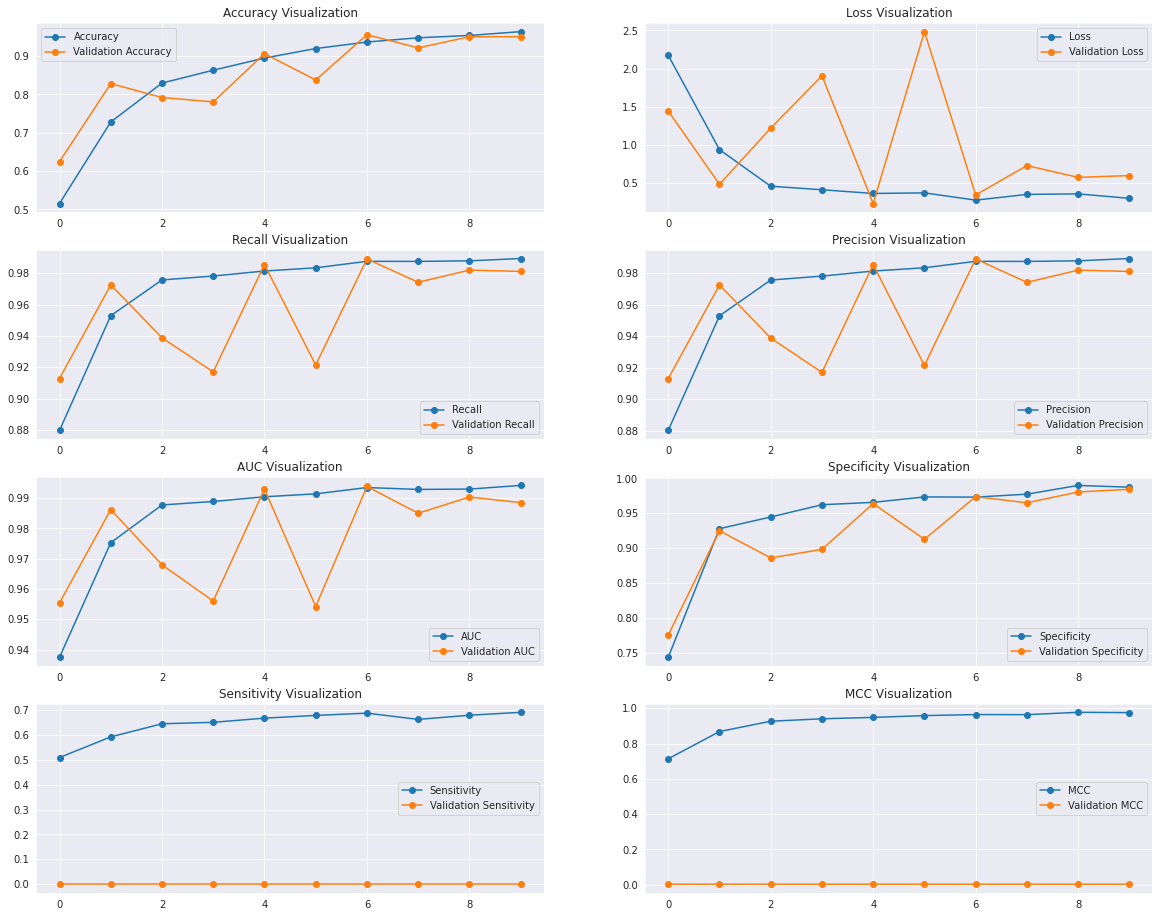

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_with_discarded_images.h5")

In [ ]:
test_predictions = final_model_resnet50.predict(test_images)
test_predictions_inverse = lb.inverse_transform(test_predictions)

In [ ]:
test_labels_inverse = lb.inverse_transform(test_labels)

In [ ]:
print(classification_report(test_labels_inverse, test_predictions_inverse))

                 precision    recall  f1-score   support

          COVID       0.98      0.87      0.92       766
   Lung opacity       0.88      0.85      0.87      1181
         Normal       0.90      0.94      0.92      2012
Viral Pneumonia       0.91      0.98      0.95       274

       accuracy                           0.91      4233
      macro avg       0.92      0.91      0.91      4233
   weighted avg       0.91      0.91      0.91      4233



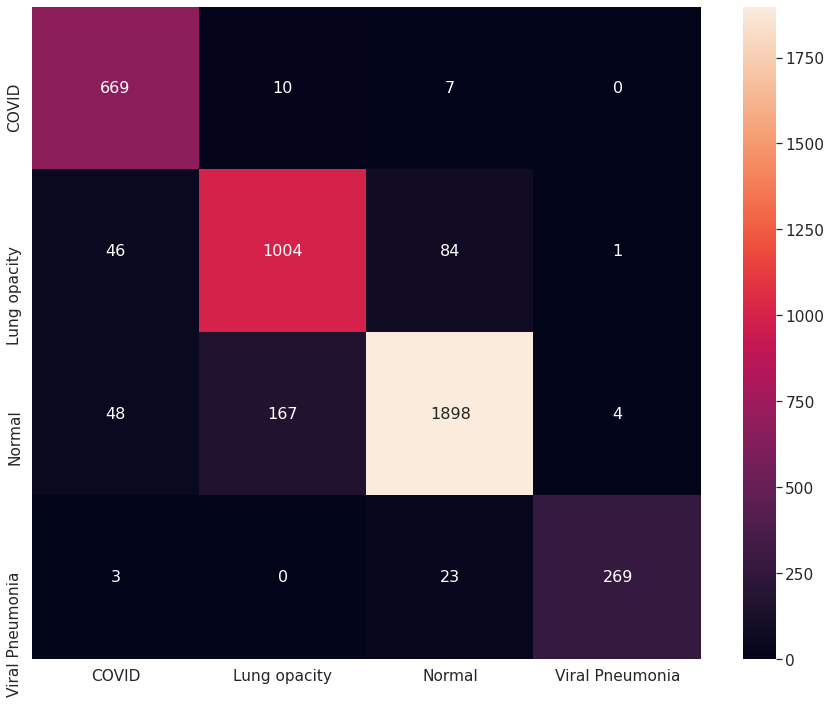

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(test_predictions_inverse, test_labels_inverse)
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

#ResNet50 with class weights

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model_resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(x=X_train_final, y=Y_train_final, epochs = 20, batch_size=32, callbacks=[early_stoping], validation_split=0.2, shuffle=True, class_weight=model_class_weights)

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.490048,0.639744,2.051775,1.403686,0.877010,0.938194,0.877516,0.938391,0.936604,0.966668,0.763261,0.886111,0.470687,0.0,0.713528,0.002357
1,0.703316,0.777865,0.728727,0.840226,0.951914,0.968364,0.951964,0.968364,0.976002,0.982377,0.891960,0.943333,0.618090,0.0,0.865361,0.003143
2,0.798308,0.773832,0.392556,2.359650,0.971400,0.916195,0.971451,0.916195,0.985595,0.953826,0.923786,0.890000,0.625628,0.0,0.902955,0.000786
3,0.850780,0.779908,0.388696,1.200645,0.976010,0.934842,0.976061,0.934842,0.987422,0.965437,0.946678,0.950555,0.623953,0.0,0.932392,0.003143
4,0.895566,0.906505,0.470596,0.445921,0.975486,0.980306,0.975486,0.980306,0.986752,0.989645,0.947515,0.976667,0.667504,0.0,0.936874,0.003143
5,0.917749,0.798240,0.388423,1.853307,0.982662,0.917243,0.982662,0.917243,0.990428,0.954176,0.973199,0.937778,0.664992,0.0,0.957873,0.003143
6,0.931263,0.929918,0.207419,2.305021,0.989629,0.966897,0.989629,0.966897,0.994681,0.979839,0.983529,0.940000,0.659966,0.0,0.970131,0.003143
7,0.941740,0.806254,0.287241,3.530436,0.986381,0.888330,0.986381,0.888330,0.992350,0.934593,0.981574,0.933889,0.659966,0.0,0.972529,0.003143
8,0.953316,0.939399,0.270487,0.482860,0.987167,0.979468,0.987167,0.979468,0.992892,0.989318,0.982412,0.987222,0.684255,0.0,0.975291,0.004303
9,0.962286,0.965012,0.243772,0.199541,0.989367,0.992667,0.989367,0.992667,0.994137,0.996359,0.981016,0.975000,0.665829,0.0,0.970710,0.004303


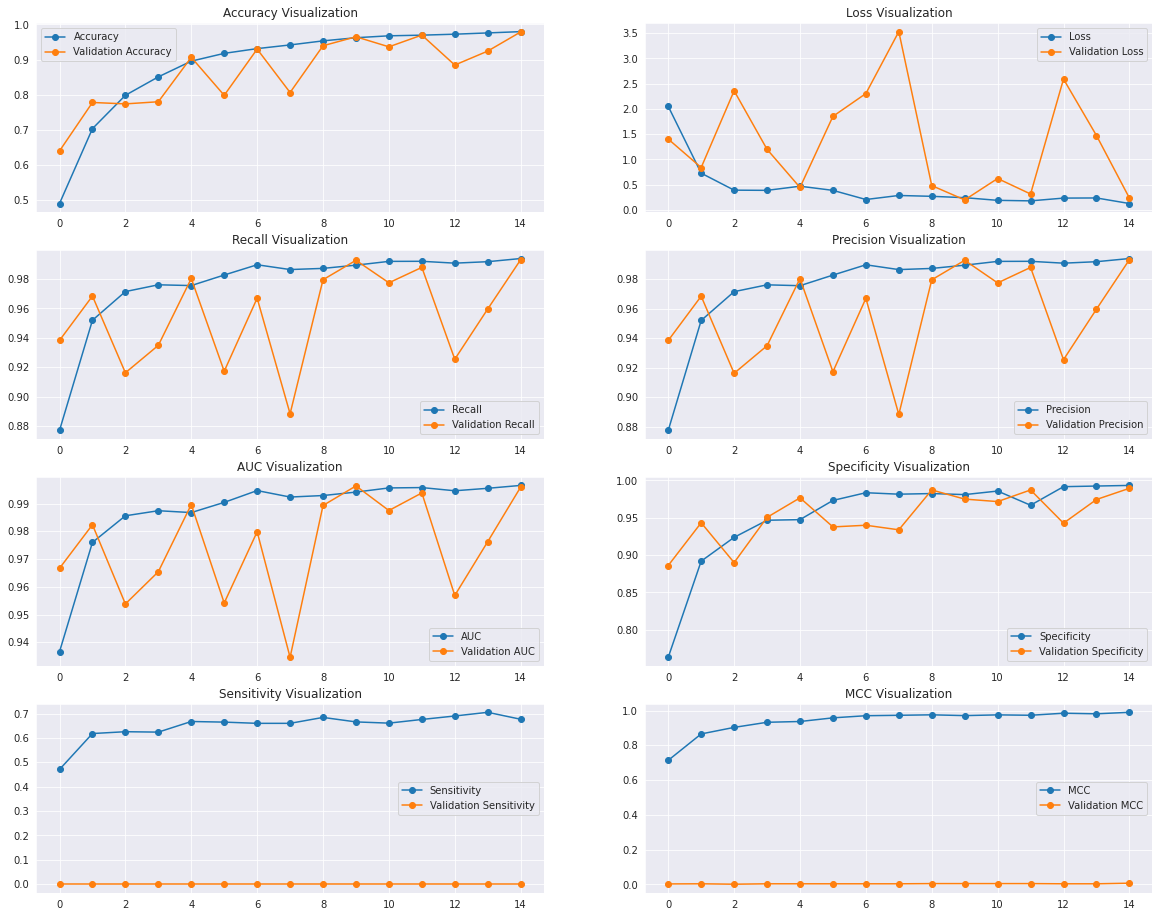

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_with_discarded_images_with_class_weights.h5")

In [ ]:
test_predictions = final_model_resnet50.predict(test_images)
test_predictions_inverse = lb.inverse_transform(test_predictions)

In [ ]:
test_labels_inverse = lb.inverse_transform(test_labels)

In [ ]:
print(classification_report(test_labels_inverse, test_predictions_inverse))

                 precision    recall  f1-score   support

          COVID       0.96      0.92      0.94       766
   Lung opacity       0.90      0.86      0.88      1181
         Normal       0.91      0.94      0.93      2012
Viral Pneumonia       0.91      1.00      0.95       274

       accuracy                           0.92      4233
      macro avg       0.92      0.93      0.92      4233
   weighted avg       0.92      0.92      0.92      4233



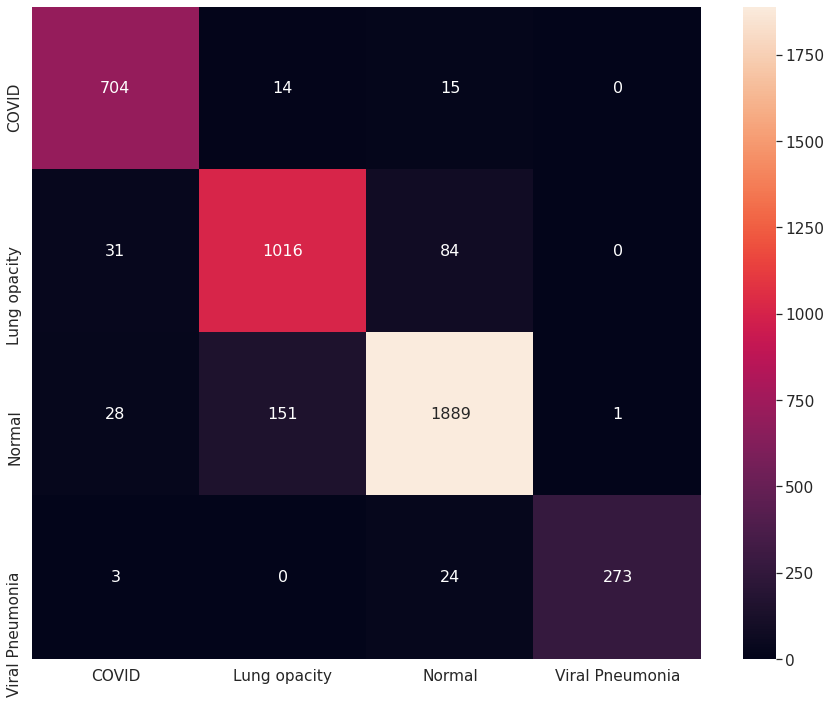

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(test_predictions_inverse, test_labels_inverse)
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()